In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir(os.path.join("drive", "Othercomputers", "My Laptop", "RP", "urban-change-detection"))
os.getcwd()

'/content/drive/Othercomputers/My Laptop/RP/urban-change-detection'

In [3]:
!pip install -r requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 47.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cac

#### Imports


In [96]:
import argparse
import sys
from importlib import reload

sys.path.insert(1, 'siamese_fcn')
sys.path.insert(1, 'datasets')
sys.path.insert(1, 'evaluation')
sys.path.insert(1, 'results')
sys.path.insert(1, 'visualization')
sys.path.insert(1, 'util')

import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import metrics
from metrics import evaluate_net_predictions
from tables import create_tables
from plots import create_figures
from tqdm import tqdm as tqdm
from preprocess_util import reshape_for_torch
from unet import Unet
from siamunet_conc import SiamUnet_conc
from siamunet_diff import SiamUnet_diff
from fresunet import FresUNet
import levir_dataset_loader
import train_test
import hrscd_dataset_loader
from levir_dataset_loader import LEVIR_Dataset
from hrscd_dataset_loader import HRSCD_Dataset
import time



reload(hrscd_dataset_loader)
reload(metrics)


<module 'metrics' from '/content/drive/Othercomputers/My Laptop/RP/urban-change-detection/evaluation/metrics.py'>

#### Load Data

In [5]:
N_EPOCHS = 50
FP_MODIFIER = 1
BATCH_SIZE = 1
PATCH_SIZE = 1024
STRIDE = 50
TEST_RUN = False
DIRNAME = os.path.join("..", "data", "HRSCD")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [81]:
import gc
torch.cuda.empty_cache()
gc.collect()

364

In [6]:
import sys

sys.path.insert(1, '../siamese_fcn')
sys.path.insert(1, '../datasets')
sys.path.insert(1, '../evaluation')
sys.path.insert(1, '../results')
sys.path.insert(1, '../visualization')
sys.path.insert(1, '..')
sys.path.insert(1, '../util')


from torch.utils.data import Dataset
import os
from preprocess_util import reshape_for_torch
import numpy as np
from tqdm import tqdm as tqdm
import cv2
import os
from math import ceil

FP_MODIFIER = 1


class HRSCD_Dataset(Dataset):

    def __init__(self, dirname, set_name, stride, patch_side):
        self.imgs_1 = {}
        self.imgs_2 = {}
        self.change_maps = {}
        self.land_cover_1 = {}
        # self.land_cover_2 = {}

        self.stride = stride
        self.dirname = dirname
        self.n_patches_per_image = {}
        self.n_patches = 0
        self.patch_coords = []
        self.patch_side = 1000
        self.set_name = set_name
        self.names = []
        n_pix = 0
        true_pix = 0

        l = len(os.listdir(os.path.join(dirname,set_name, "A")))


        for name in os.listdir(os.path.join(dirname,set_name, "A"))[: int(l//4)]:

            img_name = set_name + "-" + name
            self.names.append(img_name)
            a = reshape_for_torch(cv2.imread(os.path.join(dirname,set_name,"A", name)))
            b = reshape_for_torch(cv2.imread(os.path.join(dirname,set_name, "B", name)))
            label = cv2.imread(os.path.join(dirname, set_name, "labels", name), cv2.IMREAD_GRAYSCALE)
            land_cover_1 =  cv2.imread(os.path.join(dirname, set_name, "labels_land_cover_A", name))
            # land_cover_2 =  cv2.imread(os.path.join(dirname, set_name, "labels_land_cover_B", name), cv2.IMREAD_GRAYSCALE)

            self.imgs_1[img_name] = a
            self.imgs_2[img_name] = b
            self.change_maps[img_name] = label
            self.land_cover_1[img_name] = land_cover_1



            s = label.shape
            n_pix += np.prod(s)
            true_pix += label.sum()

            s = self.imgs_1[img_name].shape
            n1 = ceil((s[1] - self.patch_side + 1) / self.stride)
            n2 = ceil((s[2] - self.patch_side + 1) / self.stride)
            n_patches_i = n1 * n2

            self.n_patches_per_image[img_name] = n_patches_i
            self.n_patches += n_patches_i

            for i in range(n1):
                for j in range(n2):

                    current_patch_coords = (img_name,
                                    [self.stride*i, self.stride*i + self.patch_side, self.stride*j, self.stride*j + self.patch_side],
                                    [self.stride*(i + 1), self.stride*(j + 1)])

                    self.patch_coords.append(current_patch_coords)

        self.weights = [ FP_MODIFIER * 2 * true_pix / n_pix, 2 * (n_pix - true_pix) / n_pix]

    def get_img(self, im_name):
        return self.imgs_1[im_name], self.imgs_2[im_name], self.change_maps[im_name], self.land_cover_1[im_name]

    def __len__(self):
        return self.n_patches

    def __getitem__(self, idx):

        current_patch_coords = self.patch_coords[idx]
        im_name = current_patch_coords[0]
        limits = current_patch_coords[1]
        centre = current_patch_coords[2]


        I1 = self.imgs_1[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]
        I2 = self.imgs_2[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]
        label = self.change_maps[im_name][limits[0]:limits[1], limits[2]:limits[3]]
        landcover_labels_1 = self.land_cover_1[im_name][limits[0]:limits[1], limits[2]:limits[3]]
        # landcover_labels_2 = self.land_cover_2[im_name][limits[0]:limits[1], limits[2]:limits[3]]


        sample = {'I1': I1, 'I2': I2, 'label': label, "landcover": landcover_labels_1}


        return sample




In [ ]:
# train_dataset = LEVIR_Dataset(DIRNAME, "train", STRIDE, PATCH_SIZE)
# test_dataset = LEVIR_Dataset(DIRNAME, "test", STRIDE, PATCH_SIZE)
# val_dataset = LEVIR_Dataset(DIRNAME, "val", STRIDE, PATCH_SIZE)

train_dataset = HRSCD_Dataset(DIRNAME, "train", STRIDE, PATCH_SIZE)
test_dataset = HRSCD_Dataset(DIRNAME, "test", STRIDE, PATCH_SIZE)
val_dataset = HRSCD_Dataset(DIRNAME, "val", STRIDE, PATCH_SIZE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = torch.FloatTensor(train_dataset.weights).to(device)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1)

net, net_name = SiamUnet_conc(3, 2), 'FC-Siam-conc'
net.to(device)

criterion = nn.NLLLoss(weight=weights)

In [30]:
import train_test
reload(train_test)
from train_test import train

save_dir = f'{net_name}-{time.time()}.pth.tar'
training_metrics = train(net, net_name, train_dataset, train_loader, val_dataset, criterion, PATCH_SIZE, device, n_epochs=1, save=True, save_dir = save_dir)

AttributeError: 'SiamUnet_conc' object has no attribute 'dtype'

In [93]:
reload(metrics)
from metrics import evaluate_categories

categorical_metrics = evaluate_categories(net, train_dataset, ["No info", "Artificial surfaces", "Forests", "Wetlands", "Water"], 1000)

<ipython-input-90-0642680f3797>:187: RuntimeWarning: invalid value encountered in divide
  cm = (cm - np.min(cm)) / (np.max(cm) - np.min(cm))


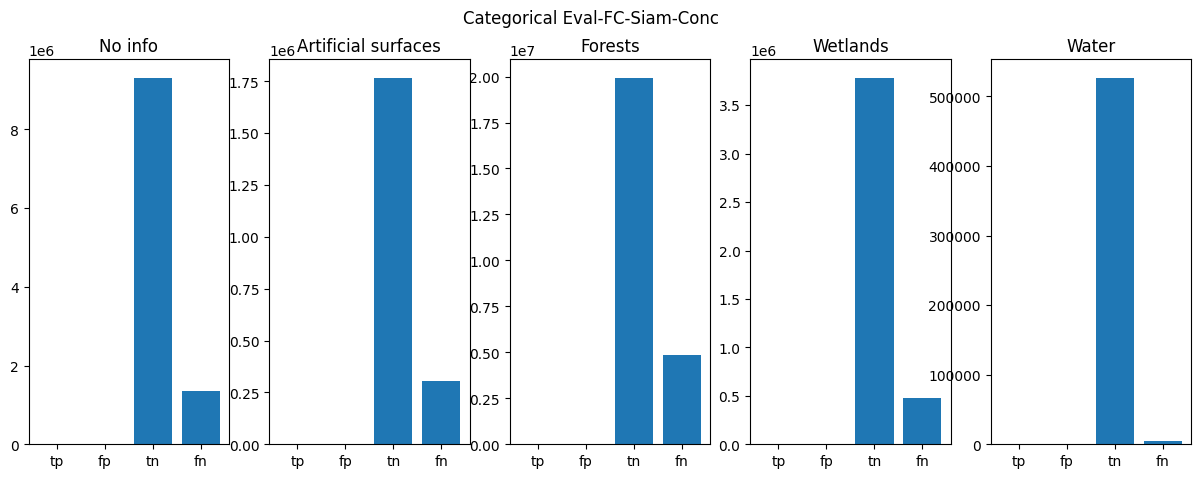

In [106]:
# import plots
from plots import category_histograms
category_histograms('FC-Siam-Conc', 'Categorical Eval', categorical_metrics )

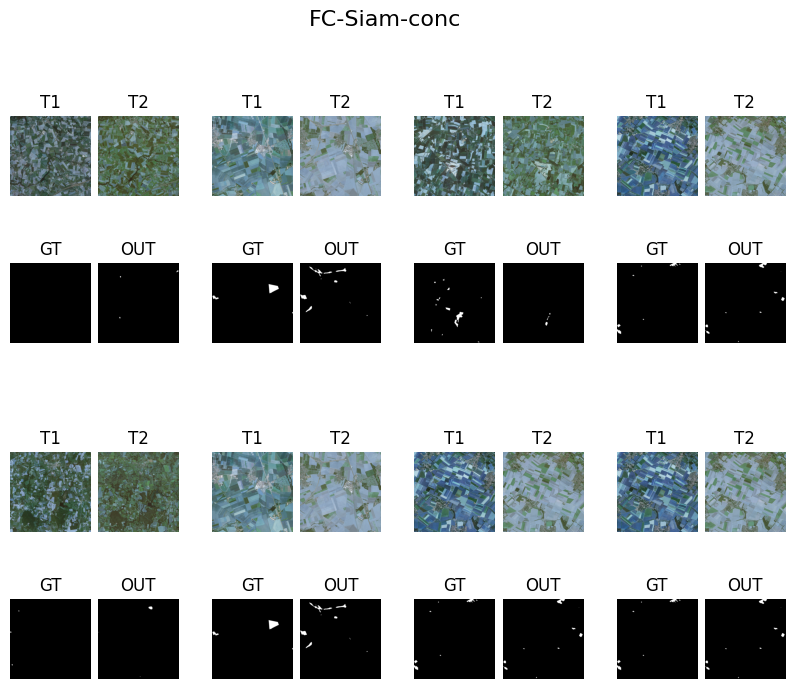

In [ ]:
import data_examination
reload(data_examination)
from data_examination import examine_subset

examine_subset(net, net_name, test_dataset, 10, device)

In [ ]:
test_metrics = evaluate_net_predictions(net, criterion, test_dataset, PATCH_SIZE)

/content/drive/Othercomputers/My Laptop/RP/urban-change-detection/evaluation/metrics.py:63: RuntimeWarning: invalid value encountered in divide
  cm = (cm - np.min(cm)) / (np.max(cm) - np.min(cm))


In [105]:
import tables
import plots
reload(tables)
reload(plots)
from tables import create_tables
from plots import create_figures


# create_figures(training_metrics, test_metrics, net_name)
# create_tables(training_metrics, test_metrics, net_name)

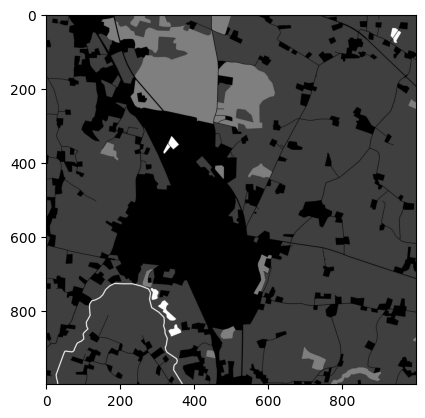

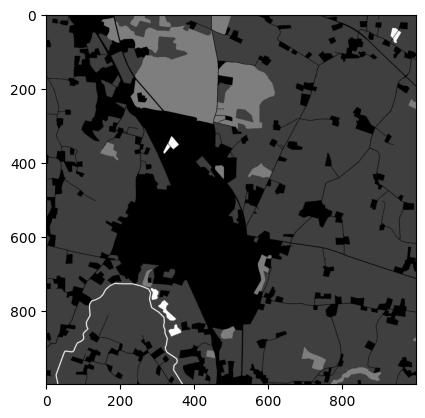

[  0  31  63 126 190 252]
[[[0 1 2]
  [0 1 2]
  [0 1 2]
  ...
  [0 1 2]
  [0 1 2]
  [0 1 2]]

 [[0 1 2]
  [0 1 2]
  [0 1 2]
  ...
  [0 1 2]
  [0 1 2]
  [0 1 2]]

 [[0 1 2]
  [0 1 2]
  [0 1 2]
  ...
  [0 1 2]
  [0 1 2]
  [0 1 2]]

 ...

 [[0 1 2]
  [0 1 2]
  [0 1 2]
  ...
  [0 1 2]
  [0 1 2]
  [0 1 2]]

 [[0 1 2]
  [0 1 2]
  [0 1 2]
  ...
  [0 1 2]
  [0 1 2]
  [0 1 2]]

 [[0 1 2]
  [0 1 2]
  [0 1 2]
  ...
  [0 1 2]
  [0 1 2]
  [0 1 2]]]


In [ ]:
b = next(iter(train_loader))
img = torch.squeeze(b['landcover']).numpy()


plt.imshow(img)
plt.show()


Z = img.reshape((-1,3))
Z = np.float32(Z)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 6
ret, label, center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

plt.imshow(res2)
plt.show()




[  0  31  63 126 190 252]


array([      0,       1,       2, ..., 2999997, 2999998, 2999999])

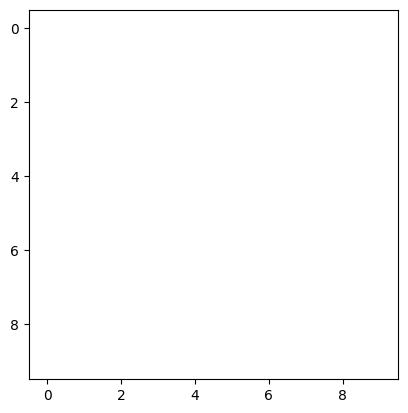

In [ ]:
plt.imshow(np.ones((10, 10, 3))*255, cmap='gray')